<a href="https://colab.research.google.com/github/rvinas/CIBERSORT/blob/master/CD_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-probability==0.8.0rc0
!pip install cdt

     |████████████████████████████████| 2.5MB 9.0MB/s 
ERROR: tensor2tensor 1.14.1 has requirement tensorflow-probability==0.7.0, but you'll have tensorflow-probability 0.8.0rc0 which is incompatible.
ERROR: gym 0.15.4 has requirement cloudpickle~=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.
  Found existing installation: cloudpickle 1.2.2
    Uninstalling cloudpickle-1.2.2:
      Successfully uninstalled cloudpickle-1.2.2
  Found existing installation: tensorflow-probability 0.7.0
    Uninstalling tensorflow-probability-0.7.0:
      Successfully uninstalled tensorflow-probability-0.7.0


     |████████████████████████████████| 921kB 9.5MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=bcf8e73f2c8b9c54cd60b75ec19d295d5101844891b7f026e4bcf04633eadf76
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
  Created wheel for skrebate: filename=skrebate-0.6-cp36-none-any.whl size=29329 sha256=ef1200c650e287572271e094d01bda37075b7122e0eef2ef786b1ae9726ffa6c
  Stored in directory: /root/.cache/pip/wheels/f5/99/36/c827bcfa6852c6d068895b2723c57cea84f93642270c6dc05c
Successfully built GPUtil skrebate


In [2]:
import numpy as np
import cdt
from cdt import SETTINGS
from cdt.causality.graph import SAM
SETTINGS.verbose=False
SETTINGS.NJOBS=16
import networkx as nx
import time
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

np.set_printoptions(precision=3)

Detecting 1 CUDA device(s).
sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


SUCCESS: Found GPU: /device:GPU:0


In [0]:
class GCN(tfkl.Layer):
    def __init__(self, units=32):
        super(GCN, self).__init__()
        self.units = units

    def build(self, input_shape):
        # print('GCN input shape', input_shape)
        bs, nb_vars, dim = input_shape[0]

        self.w = self.add_weight(shape=(dim, self.units),
                              initializer='random_normal',
                              trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                             initializer='random_normal',
                             trainable=True)
        super(GCN, self).build(input_shape)
    
    
    def call(self, inputs):
        h, adj = inputs

        # Compute normalized adjacency matrix
        nb_vars = adj.shape[0]
        adj_hat = adj + tf.linalg.diag(tf.ones(nb_vars))
        d_hat = tf.reduce_sum(adj_hat, axis=-1)  # Degree of each variable
        d_hat_sqrt = tf.linalg.diag(tf.sqrt(d_hat))
        norm_adj_hat = d_hat_sqrt @ adj_hat @ d_hat_sqrt

        # Perform graph convolutions
        h_t = tf.transpose(h, perm=(0, 2, 1))  # (bs, dim, nb_vars)
        norm_adj_hat_t = tf.transpose(norm_adj_hat, perm=(1, 0))  # Shape=(nb_vars, nb_vars)
        out = tf.transpose(h_t @ norm_adj_hat_t, perm=((0, 2, 1))) @ self.w # + self.b

        return out
    

class Encoder(tfkl.Layer):
    def __init__(self):
        super(Encoder, self).__init__()

    def build(self, input_shape):
        print(input_shape)
        bs, nb_vars = input_shape
        self.loc = self.add_weight(shape=(nb_vars,),
                              initializer='random_normal',
                              trainable=True)
        # tfkl.Dense(nb_vars)
        self.scale = self.add_weight(shape=(nb_vars,),
                              initializer='random_normal',
                              trainable=True)
        
        # tfkl.Dense(nb_vars, activation=tf.nn.softplus)
        # self._trainable_weights = [self.loc.trainable_weights, self.scale.trainable_weights]
        super(Encoder, self).build(input_shape)

    def call(self, x):
        bs = x.shape[0]
        loc = tf.zeros_like(x) + self.loc
        scale = tf.zeros_like(x) + self.scale
        return tfd.MultivariateNormalDiag(loc,  # (x),
                                          scale)  # (x))

class Decoder(tfkl.Layer):
    def __init__(self, v = 0.01):
        super(Decoder, self).__init__()
        self.v = v

    def build(self, input_shape):
        # Input shape: (bs, nb_vars)
        nb_vars = input_shape[-1]
        p = self.add_weight(shape=(nb_vars, nb_vars),
                            initializer=lambda shape, dtype: tf.ones(shape, dtype=dtype)/2,
                            trainable=True,
                            constraint=lambda t: tf.clip_by_value(t, self.v, 1-self.v))
        mask = 1 - tf.linalg.diag(tf.ones(nb_vars))
        self.p = p * mask
        self.f = GCN(2)
        super(Decoder, self).build(input_shape)

    def call(self, x, temperature = 1):
        a = tfd.RelaxedBernoulli(temperature, probs=self.p).sample()
        self.a = a
        e = x[..., None]  # Noise terms for each variable. Shape=(bs, nb_vars, 1) 
        h = self.f([e, a])  # Shape=(bs, nb_vars, 2)
        loc = h[..., 0]
        scale = h[..., 1]
        out = tfd.MultivariateNormalDiag(loc, scale)
        return out
    
    def structural_regularizer(self):
        return tf.reduce_sum(self.p)  # tf.reduce_sum(self.a)

def prior(nb_vars):
    loc = tf.zeros(nb_vars)
    scale = tf.ones(nb_vars)
    return tfd.MultivariateNormalDiag(loc, scale)

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,-0.725941,-0.944743,-3.399540,-2.844207,-3.193719,-1.448650,-3.407909,-3.898694,-3.704926,-3.515870
1,-0.800856,-0.173580,-3.490670,-2.723656,-3.438987,-0.814140,-3.090658,-3.513363,-3.719015,-3.554667
2,-0.702618,0.178546,-3.516439,-2.561114,-2.632457,-0.664811,-2.870183,-3.076491,-3.251564,-3.375902
3,-0.827770,-0.220522,-3.597374,-2.821905,-3.444674,-1.233935,-3.224829,-3.925705,-3.778895,-3.560724
4,-1.161090,-1.015694,-3.027568,-2.989479,-3.005508,-1.488517,-3.225774,-3.645730,-3.429701,-3.072662
...,...,...,...,...,...,...,...,...,...,...
1995,1.544593,0.713946,0.812751,1.898658,2.250012,0.929556,1.694214,1.388380,2.017699,2.137791
1996,0.517252,0.725727,0.129506,0.694814,1.067822,0.671419,0.603003,0.802267,0.820466,0.727026
1997,1.174755,2.215882,0.651272,1.950053,1.153441,2.543117,2.211590,1.096531,1.496808,1.285926
1998,0.031010,-0.605009,0.412085,0.087896,0.276887,-0.376853,0.084329,0.257353,0.234775,0.306465


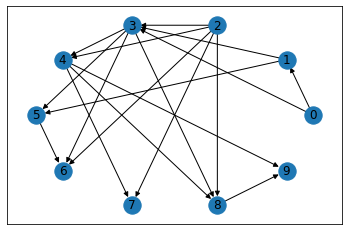

In [21]:
# Load data
nb_vars = 10
nb_samples = 2000
agg = cdt.data.AcyclicGraphGenerator(causal_mechanism='linear',
                                     npoints=nb_samples,
                                     nodes=nb_vars,
                                     parents_max=3,
                                     expected_degree=3)
data, g = agg.generate()
nx.draw_networkx(g, pos=nx.circular_layout(g))
data

In [22]:
lambda_struct = 0.001
beta = 10

x_ = tf.placeholder(tf.float32, [None, nb_vars])
encoder = Encoder()
decoder = Decoder()

posterior = encoder(x_)  # Posterior approximation
code = posterior.sample()

log_likelihood = -tf.losses.mean_squared_error(x_, decoder(code).sample())
divergence = tf.reduce_mean(tfd.kl_divergence(posterior, prior(nb_vars)))

elbo = log_likelihood - beta * divergence
structural_L = lambda_struct * decoder.structural_regularizer()
L =  structural_L - elbo

(?, 10)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
lr = 0.001
bs = 32
epochs = 200

optimize = tf.train.AdamOptimizer(lr).minimize(L)
optimize_elbo = tf.train.AdamOptimizer(lr).minimize(-elbo)
optimize_structure = tf.train.AdamOptimizer(lr).minimize(structural_L)

In [24]:
x = data.values

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(epochs):

        for i in range(0, len(x), bs):
            x_batch = x[i: i+bs, :]
            # _, loss, elbo_loss, s_loss, div_loss, log_loss = sess.run([optimize_elbo, L, elbo, structural_L, divergence, log_likelihood], {x_: x_batch})
            # _, loss, elbo_loss, s_loss, div_loss, log_loss = sess.run([optimize_structure, L, elbo, structural_L, divergence, log_likelihood], {x_: x_batch})
            _, loss, elbo_loss, s_loss, div_loss, log_loss = sess.run([optimize, L, elbo, structural_L, divergence, log_likelihood], {x_: x_batch})
            # print('Div loss: {:.2f}'.format(div_loss))
            # print('Log loss: {:.2f}'.format(log_loss))
            # print(sess.run(decoder(code).sample(), {x_: x_batch})[0])

        print('Epoch: {}, loss: {:.2f}, -elbo: {:.2f}, s_loss: {:.4f}'.format(epoch, loss, -elbo_loss, s_loss))
    
    prob_edges = sess.run(decoder.p)

Epoch: 0, loss: 189.28, -elbo: 189.23, s_loss: 0.0422
Epoch: 1, loss: 153.73, -elbo: 153.69, s_loss: 0.0384
Epoch: 2, loss: 130.95, -elbo: 130.92, s_loss: 0.0350
Epoch: 3, loss: 114.19, -elbo: 114.16, s_loss: 0.0313
Epoch: 4, loss: 100.94, -elbo: 100.91, s_loss: 0.0274
Epoch: 5, loss: 90.04, -elbo: 90.02, s_loss: 0.0234
Epoch: 6, loss: 80.84, -elbo: 80.82, s_loss: 0.0191
Epoch: 7, loss: 72.92, -elbo: 72.91, s_loss: 0.0147
Epoch: 8, loss: 66.02, -elbo: 66.01, s_loss: 0.0102
Epoch: 9, loss: 59.93, -elbo: 59.93, s_loss: 0.0060
Epoch: 10, loss: 54.52, -elbo: 54.51, s_loss: 0.0034
Epoch: 11, loss: 49.67, -elbo: 49.67, s_loss: 0.0020
Epoch: 12, loss: 45.32, -elbo: 45.32, s_loss: 0.0013
Epoch: 13, loss: 41.38, -elbo: 41.38, s_loss: 0.0011
Epoch: 14, loss: 37.82, -elbo: 37.82, s_loss: 0.0010
Epoch: 15, loss: 34.58, -elbo: 34.57, s_loss: 0.0009
Epoch: 16, loss: 31.62, -elbo: 31.62, s_loss: 0.0009
Epoch: 17, loss: 28.93, -elbo: 28.93, s_loss: 0.0009
Epoch: 18, loss: 26.46, -elbo: 26.46, s_loss: 

In [25]:
edges = prob_edges > 0.5
reconstructed_g = nx.DiGraph(edges)
prob_edges

array([[0.   , 0.011, 0.01 , 0.01 , 0.01 , 0.02 , 0.01 , 0.01 , 0.01 ,
        0.01 ],
       [0.01 , 0.   , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
        0.01 ],
       [0.01 , 0.01 , 0.   , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
        0.01 ],
       [0.01 , 0.01 , 0.01 , 0.   , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
        0.01 ],
       [0.01 , 0.01 , 0.01 , 0.01 , 0.   , 0.01 , 0.01 , 0.01 , 0.01 ,
        0.01 ],
       [0.01 , 0.012, 0.01 , 0.01 , 0.01 , 0.   , 0.01 , 0.01 , 0.01 ,
        0.013],
       [0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.   , 0.012, 0.01 ,
        0.01 ],
       [0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.   , 0.01 ,
        0.01 ],
       [0.01 , 0.01 , 0.01 , 0.012, 0.01 , 0.01 , 0.011, 0.01 , 0.   ,
        0.01 ],
       [0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 , 0.01 ,
        0.   ]], dtype=float32)

In [0]:
edges

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

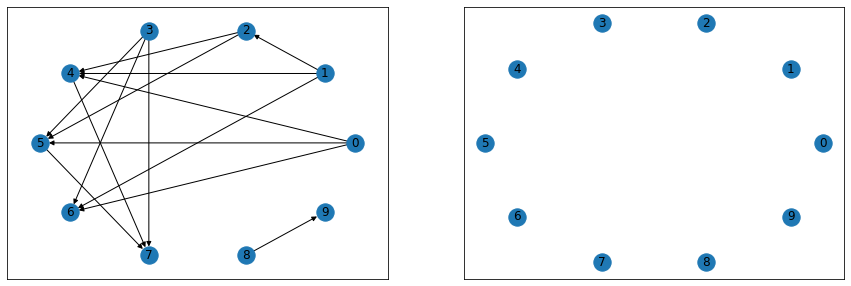

In [0]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
nx.draw_networkx(g, pos=nx.circular_layout(g))
plt.subplot(1, 2, 2)
nx.draw_networkx(reconstructed_g, pos=nx.circular_layout(reconstructed_g))